In [67]:
import csv  
import numpy as np
import numpy.random
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng
plt.rcParams['figure.figsize'] = [20, 19]

In [68]:
def get_cards(x):
    cards = np.array([
        card for card in range(1,14) # Values
        for suits in range(1,5)      # Suits
        for num_decks in range(x)  # Number of decks
    ])
    rng = default_rng()
    rng.shuffle(cards)
    return cards

In [69]:
def pop(arr, n=1):
    select, arr = arr[-n:], arr[:-n]
    return np.array([10 if i > 10 else (11 if i == 1 else i) for i in select]), arr, 1 in select[-1::2]

In [70]:
class Table:
    def __init__(self,cards):
        self.dealer_total = None
        self.player_total = None
        self.dealer_card = None
        self.ace_check1 = False
        self.last_card = None
        self.cards = cards

    def start(self):
        self.last_card = None
        picked, self.cards, self.ace_check1 = pop(self.cards, 4)
        self.dealer_card = picked[2]
        self.player_total = picked[3]+picked[1]
        if self.player_total == 22:
            self.player_total == 12
        self.dealer_total = picked[2]+picked[0]

    def player_hit(self):
        hand, self.cards, ace_check2 = pop(self.cards)
        if self.player_total+hand[0] > 21 and (self.ace_check1 or ace_check2): #If contains ace and > 21 change ace to 1
            self.ace_check1 = False
            self.last_card = 1 if hand[0] == 11 else hand[0]
            self.player_total+=(-10 + hand[0])
        else:
            self.last_card = hand[0]
            self.player_total+=hand[0]

    def dealer_hit(self):
        hand, self.cards, _ = pop(self.cards)
        self.dealer_total+=hand[0]

    def get_player_last_hand(self):
        return self.player_total-self.last_card if self.last_card else self.player_total

    def reset_deck(self, n_decks):
        self.cards = get_cards(n_decks)

In [71]:
def play_blackjack(num, n_decks=8, dealer_threshold=17):
    rng = default_rng()
    table = Table(get_cards(n_decks))

    with open('result2.csv', 'w', encoding='UTF8') as f:
        writer = csv.writer(f)
        writer.writerow(['player_hand','dealer_card', 'hit', 'win'])
    
        for _ in range(num):
            table.start()
            dealer_hand = table.dealer_card
            hit = False
            if len(table.cards) < (n_decks/2)*52:
                table.reset_deck(8)

            # If dealer Blackjack right away, player lose
            if table.dealer_total == 21:
                writer.writerow([table.player_total,dealer_hand, 0, 0])
                continue

            while rng.choice([True, False]) and table.player_total <= 21:
                hit = True
                table.player_hit()

            player_hand = table.get_player_last_hand()

            # If player over 21 lose
            if table.player_total > 21:
                writer.writerow([player_hand,dealer_hand, 1 if hit else 0, 0])
                continue

            ## Dealer Deals
            while table.dealer_total < dealer_threshold:
                table.dealer_hit()

            if table.dealer_total > 21:
                writer.writerow([player_hand,dealer_hand, 1 if hit else 0, 1])
            elif table.dealer_total > table.player_total:
                writer.writerow([player_hand,dealer_hand,1 if hit else 0, 0])
            elif table.player_total > table.dealer_total:
                writer.writerow([player_hand,dealer_hand,1 if hit else 0, 1])

        print(f'Completed')

In [72]:
play_blackjack(1_000_000, n_decks=8)
df = pd.read_csv("result2.csv")

Completed


## P(Win | Stand) Matrix

In [73]:
player_hands = np.arange(3,22)
dealer_hands = np.arange(2,12)

p_win_given_stand = []

for dealer in range(2,12):
    for player in range(3,22):
        display = df[(df['player_hand'] == player) & (df['dealer_card'] == dealer)]
        stand = display[display['hit'] == 0]
        total_stand = 1e-7 if len(stand) == 0 else len(stand)
        p = len(stand[stand['win'] == 1])/total_stand
        p_win_given_stand.append(round(p,3))

p_win_given_stand = np.array(p_win_given_stand, dtype='f').reshape(len(dealer_hands), len(player_hands))

## P(Win | Hit) Matrix

In [74]:
player_hands = np.arange(3,22)
dealer_hands = np.arange(2,12)

p_win_given_hit = []

for dealer in range(2,12):
    for player in range(3,22):
        display = df[(df['player_hand'] == player) & (df['dealer_card'] == dealer)]
        hit = display[display['hit'] == 1]
        total_hit = 1e-7 if len(hit) == 0 else len(hit)
        p = len(hit[hit['win'] == 1])/total_hit
        p_win_given_hit.append(round(p,3))

p_win_given_hit = np.array(p_win_given_hit, dtype='f').reshape(len(dealer_hands), len(player_hands))

## Hit > Stand Matrix

In [75]:
determine = (p_win_given_hit > p_win_given_stand)

# Visualise

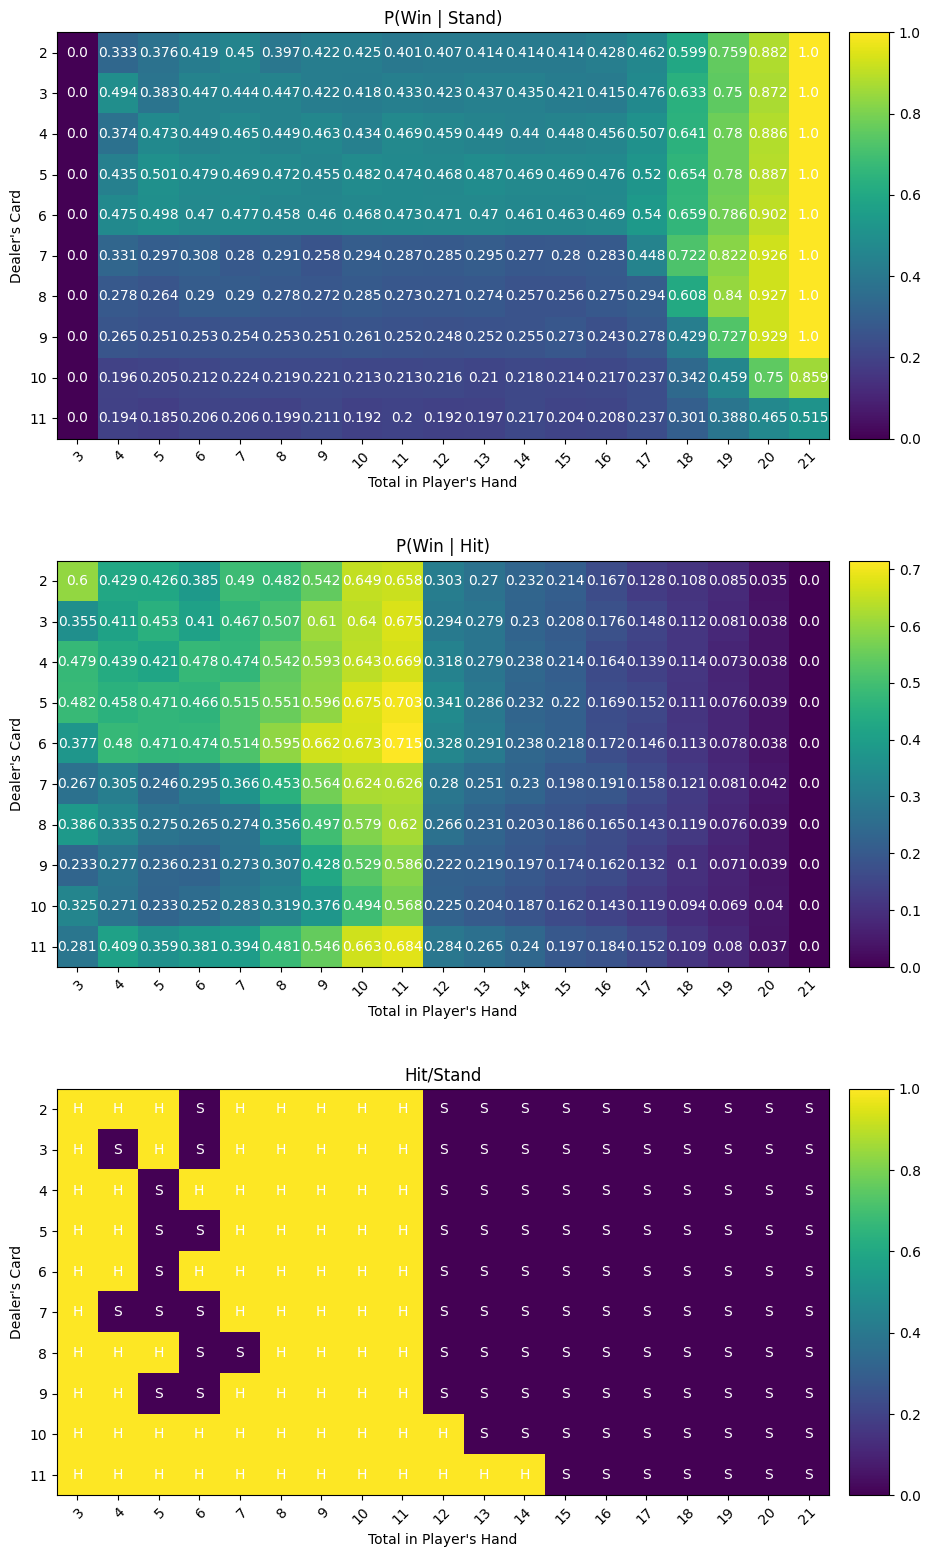

In [76]:
fig, axes = plt.subplots(3,1)
ax, ax2, ax3 = axes
plt.subplots_adjust(hspace=0.3)
im = ax.imshow(p_win_given_stand)
im2 = ax2.imshow(p_win_given_hit)
im3 = ax3.imshow(determine)

### Heat Map 1 Formatting
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(player_hands)), labels=player_hands)
ax.set_yticks(np.arange(len(dealer_hands)), labels=dealer_hands)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(dealer_hands)):
    for j in range(len(player_hands)):
        text = ax.text(j, i, p_win_given_stand[i, j],
                       ha="center", va="center", color="w")

ax.set_title("P(Win | Stand)")
ax.set(xlabel="Total in Player's Hand", ylabel="Dealer's Card")
# fig.tight_layout()
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)

### Heat Map 2 Formatting
# Show all ticks and label them with the respective list entries
ax2.set_xticks(np.arange(len(player_hands)), labels=player_hands)
ax2.set_yticks(np.arange(len(dealer_hands)), labels=dealer_hands)

# Rotate the tick labels and set their alignment.
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(dealer_hands)):
    for j in range(len(player_hands)):
        text = ax2.text(j, i, p_win_given_hit[i, j],
                       ha="center", va="center", color="w")

ax2.set_title("P(Win | Hit)")
ax2.set(xlabel="Total in Player's Hand", ylabel="Dealer's Card")
cax = fig.add_axes([ax2.get_position().x1+0.01,ax2.get_position().y0,0.02,ax2.get_position().height])
plt.colorbar(im2, cax=cax)

### Heat Map 3 Formatting
# Show all ticks and label them with the respective list entries
ax3.set_xticks(np.arange(len(player_hands)), labels=player_hands)
ax3.set_yticks(np.arange(len(dealer_hands)), labels=dealer_hands)

# Rotate the tick labels and set their alignment.
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(dealer_hands)):
    for j in range(len(player_hands)):
        text = ax3.text(j, i, "H" if determine[i, j] else "S",
                        ha="center", va="center", color="w")

ax3.set_title("Hit/Stand")
ax3.set(xlabel="Total in Player's Hand", ylabel="Dealer's Card")
cax = fig.add_axes([ax3.get_position().x1+0.01,ax3.get_position().y0,0.02,ax3.get_position().height])
plt.colorbar(im3, cax=cax)

plt.savefig('Visual_1.png', transparent=True, bbox_inches='tight')
plt.show()

In [79]:
def play_blackjack_with_p(num, probability, n_decks=8,dealer_threshold=17):
    table = Table(get_cards(n_decks))
    lose = 0
    push = 0
    win = 0

    for _ in range(num):
        table.start()
        if len(table.cards) < (n_decks/2)*52:
            table.reset_deck(8)

        # If dealer Blackjack right away, player lose
        if table.dealer_total == 21:
            lose+=1
            continue

        while table.player_total < 21 and probability[table.dealer_card-2,table.player_total-3]:
            table.player_hit()

        # If player over 21 lose
        if table.player_total > 21:
            lose+=1
            continue

        ## Dealer Deals
        while table.dealer_total < dealer_threshold:
            table.dealer_hit()

        if table.dealer_total > 21:
            # write the data
            win+=1
        elif table.player_total > table.dealer_total:
            win+=1
        elif table.dealer_total > table.player_total:
            lose+=1
        else:
            push+=1
    print(f'Win: {win}, Lost: {lose}, Push: {push}, Winrate: {(win/num) * 100}%')
    return win, lose, push

In [80]:
play_blackjack_with_p(1000000, determine, n_decks=8)

Win: 444872, Lost: 492209, Push: 62919, Winrate: 44.4872%


(444872, 492209, 62919)